In [20]:
import cv2
import torch
import dlib
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from lib.backbone import StackedHGNetV1

In [2]:
class Model_Config:
    def __init__(self):
        self.classes_num = [68, 9, 68]
        self.edge_info = (
                (False, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)),  # FaceContour
                (False, (17, 18, 19, 20, 21)),  # RightEyebrow
                (False, (22, 23, 24, 25, 26)),  # LeftEyebrow
                (False, (27, 28, 29, 30)),  # NoseLine
                (False, (31, 32, 33, 34, 35)),  # Nose
                (True, (36, 37, 38, 39, 40, 41)),  # RightEye
                (True, (42, 43, 44, 45, 46, 47)),  # LeftEye
                (True, (48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)),  # OuterLip
                (True, (60, 61, 62, 63, 64, 65, 66, 67)),  # InnerLip
            )
        self.nstack = 4
        self.add_coord = True
        self.decoder_type = "default"
        self.width = 256
        self.height = 256
        self.use_AAM = True

In [3]:
model_config = Model_Config()
net = StackedHGNetV1(config=model_config,
                        classes_num=model_config.classes_num,
                        edge_info=model_config.edge_info,
                        nstack=model_config.nstack,
                        add_coord=model_config.add_coord,
                        decoder_type=model_config.decoder_type)

In [8]:
model_path = "300W_STARLoss_NME_2_87.pkl"
checkpoint = torch.load(model_path)
net.load_state_dict(checkpoint["net"])

/tmp/ipykernel_16611/764859214.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


<All keys matched successfully>

In [10]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)

In [13]:
face_file_path = 'pub_dataset/WFLW/WFLW_images/8--Election_Campain/8_Election_Campain_Election_Campaign_8_25.jpg'
image = cv2.imread(face_file_path)

In [17]:
class GetCropMatrix():
    """
    from_shape -> transform_matrix
    """

    def __init__(self, image_size, target_face_scale, align_corners=False):
        self.image_size = image_size
        self.target_face_scale = target_face_scale
        self.align_corners = align_corners

    def _compose_rotate_and_scale(self, angle, scale, shift_xy, from_center, to_center):
        cosv = math.cos(angle)
        sinv = math.sin(angle)

        fx, fy = from_center
        tx, ty = to_center

        acos = scale * cosv
        asin = scale * sinv

        a0 = acos
        a1 = -asin
        a2 = tx - acos * fx + asin * fy + shift_xy[0]

        b0 = asin
        b1 = acos
        b2 = ty - asin * fx - acos * fy + shift_xy[1]

        rot_scale_m = np.array([
            [a0, a1, a2],
            [b0, b1, b2],
            [0.0, 0.0, 1.0]
        ], np.float32)
        return rot_scale_m

    def process(self, scale, center_w, center_h):
        if self.align_corners:
            to_w, to_h = self.image_size - 1, self.image_size - 1
        else:
            to_w, to_h = self.image_size, self.image_size

        rot_mu = 0
        scale_mu = self.image_size / (scale * self.target_face_scale * 200.0)
        shift_xy_mu = (0, 0)
        matrix = self._compose_rotate_and_scale(
            rot_mu, scale_mu, shift_xy_mu,
            from_center=[center_w, center_h],
            to_center=[to_w / 2.0, to_h / 2.0])
        return matrix


class TransformPerspective():
    """
    image, matrix3x3 -> transformed_image
    """

    def __init__(self, image_size):
        self.image_size = image_size

    def process(self, image, matrix):
        return cv2.warpPerspective(
            image, matrix, dsize=(self.image_size, self.image_size),
            flags=cv2.INTER_LINEAR, borderValue=0)


class TransformPoints2D():
    """
    points (nx2), matrix (3x3) -> points (nx2)
    """

    def process(self, srcPoints, matrix):
        # nx3
        desPoints = np.concatenate([srcPoints, np.ones_like(srcPoints[:, [0]])], axis=1)
        desPoints = desPoints @ np.transpose(matrix)  # nx3
        desPoints = desPoints[:, :2] / desPoints[:, [2, 2]]
        return desPoints.astype(srcPoints.dtype)


class Alignment:
    def __init__(self, model):
        self.input_size = 256
        self.target_face_scale = 1.0

        self.model =model
        self.model.eval()
        self.getCropMatrix = GetCropMatrix(image_size=self.input_size, target_face_scale=self.target_face_scale,
                                           align_corners=True)
        self.transformPerspective = TransformPerspective(image_size=self.input_size)
        self.transformPoints2D = TransformPoints2D()

    def norm_points(self, points, align_corners=False):
        if align_corners:
            # [0, SIZE-1] -> [-1, +1]
            return points / torch.tensor([self.input_size - 1, self.input_size - 1]).to(points).view(1, 1, 2) * 2 - 1
        else:
            # [-0.5, SIZE-0.5] -> [-1, +1]
            return (points * 2 + 1) / torch.tensor([self.input_size, self.input_size]).to(points).view(1, 1, 2) - 1

    def denorm_points(self, points, align_corners=False):
        if align_corners:
            # [-1, +1] -> [0, SIZE-1]
            return (points + 1) / 2 * torch.tensor([self.input_size - 1, self.input_size - 1]).to(points).view(1, 1, 2)
        else:
            # [-1, +1] -> [-0.5, SIZE-0.5]
            return ((points + 1) * torch.tensor([self.input_size, self.input_size]).to(points).view(1, 1, 2) - 1) / 2

    def preprocess(self, image, scale, center_w, center_h):
        matrix = self.getCropMatrix.process(scale, center_w, center_h)
        input_tensor = self.transformPerspective.process(image, matrix)
        input_tensor = input_tensor[np.newaxis, :]

        input_tensor = torch.from_numpy(input_tensor)
        input_tensor = input_tensor.float().permute(0, 3, 1, 2)
        input_tensor = input_tensor / 255.0 * 2.0 - 1.0
        # input_tensor = input_tensor.to(self.model.device)
        return input_tensor, matrix

    def postprocess(self, srcPoints, coeff):
        # dstPoints = self.transformPoints2D.process(srcPoints, coeff)
        # matrix^(-1) * src = dst
        # src = matrix * dst
        dstPoints = np.zeros(srcPoints.shape, dtype=np.float32)
        for i in range(srcPoints.shape[0]):
            dstPoints[i][0] = coeff[0][0] * srcPoints[i][0] + coeff[0][1] * srcPoints[i][1] + coeff[0][2]
            dstPoints[i][1] = coeff[1][0] * srcPoints[i][0] + coeff[1][1] * srcPoints[i][1] + coeff[1][2]
        return dstPoints

    def analyze(self, image, scale, center_w, center_h):
        input_tensor, matrix = self.preprocess(image, scale, center_w, center_h)


        with torch.no_grad():
            output = self.model(input_tensor)
        landmarks = output[-1][0]

        landmarks = self.denorm_points(landmarks)
        landmarks = landmarks.data.cpu().numpy()[0]
        landmarks = self.postprocess(landmarks, np.linalg.inv(matrix))

        return landmarks



In [18]:
alignment = Alignment(model=net)

In [21]:
dets = detector(image, 1)
for detection in dets:
    face = sp(image,detection)
    shape = []
    for i in range(68):
        x = face.part(i).x
        y = face.part(i).y
        shape.append((x, y))
    shape = np.array(shape)
    # image_draw = draw_pts(image_draw, shape)
    x1, x2 = shape[:, 0].min(), shape[:, 0].max()
    y1, y2 = shape[:, 1].min(), shape[:, 1].max()
    scale = min(x2 - x1, y2 - y1) / 200 * 1.05
    center_w = (x2 + x1) / 2
    center_h = (y2 + y1) / 2

    scale, center_w, center_h = float(scale), float(center_w), float(center_h)

    landmarks_pv = alignment.analyze(image, scale, center_w, center_h)

/home/groups/sammer/haogeh/Python/asymm/STAR/.venv/lib/python3.9/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Number of faces detected: 1
Detection 0: Left: 572 Top: 201 Right: 758 Bottom: 387


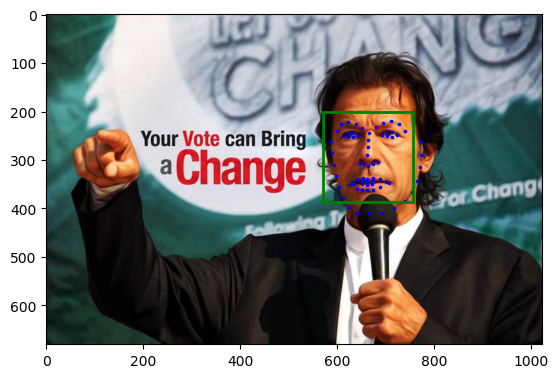

In [22]:
img = image.copy()
landmarks = landmarks_pv
print("Number of faces detected: {}".format(len(dets)))
for k, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        k, d.left(), d.top(), d.right(), d.bottom()))
    # Get the landmarks/parts for the face in box d.
    d_left = d.left()
    d_top = d.top()
    d_right = d.right()
    d_bottom = d.bottom()

    x = d_left
    y = d_top
    w = d_right - d_left
    h = d_bottom - d_top
    
    bbox = (x, y, w, h)
    # output = predictor.inference(img, [bbox])
    # # Draw the face landmarks on the screen.
    # landmarks = np.array(output['landmarks']).squeeze()
    
    x, y, w, h = map(int, bbox)

    fig, ax = plt.subplots(1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Display the image
    ax.imshow(img)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='b')
    plt.show()